# Poisson 2d
---

Consider the 2d Poisson Equation
\begin{equation}
\begin{aligned}
&\nabla \cdot (\sigma \nabla u) = 0, \\
&u|_{\partial\Omega} = g, \\
\end{aligned}
\end{equation}
where the domain $\Omega = [0, 1]\times [0, 1]$, and the target field $\sigma(x, y)\equiv 1$.
$g$ is chosen such that the exact solution is
\begin{equation}
u(x, y) = \exp(\pi y)\sin(\pi x).
\end{equation}

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("./"))))

import torch
import torch.nn as nn
import numpy as np

from pinn_lightning.pinn import PINN, InversePINN, Task
from pinn_lightning.data.dataset import PINNDataModule
from pinn_lightning.data.utils import tensor_grid, tensors_from_numpy
from pinn_lightning.utils.basic_nets import *
from pinn_lightning.utils.operators import grad, directional_grad

import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

import random
torch.manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

# Step 1: Define Model

In [2]:
class Poisson2d(PINN):	
	def get_output(self, batch_input):
		(x_domain, y_domain), (x_bc, y_bc) = batch_input
		x_domain.requires_grad = True
		y_domain.requires_grad = True
		u_domain = self.forward(torch.hstack([x_domain, y_domain]))
		eq = grad(grad(u_domain, x_domain), x_domain) + \
			grad(grad(u_domain, y_domain), y_domain)
		
		u_bc = self.forward(torch.hstack([x_bc, y_bc]))
		return eq, u_bc

forward_module = DenseNet(
	[2] + [128]*6 + [1], Swish,
)

pinn = Poisson2d(forward_module)
pinn.configure_tasks(
	[
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
		),
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 100.0,
		),
	]
)
optimizer = torch.optim.Adam(
	[
		{
			"params": pinn.param_groups[0],
			"lr": 1e-2,
			"weight_decay": 1e-6
		},
	]
)
pinn.configure_optimizers_and_schedulers(
	optimizer = optimizer,
	lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		optimizer,
		factor = 0.8,
		patience = 50,
		threshold = 1e-6,
		min_lr = 1e-4,
	),
)
pinn

Poisson2d(
  (forward_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Swish()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Swish()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): Swish()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): Swish()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): Swish()
      (12): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

# Step 2: Generate Dataset

In [3]:
x_1d = np.linspace(0, 1, 100).reshape((-1, 1))
y_1d = np.linspace(0, 1, 100).reshape((-1, 1))
xy = tensor_grid([x_1d, y_1d])
x_domain, y_domain = xy[:, 0:1], xy[:, 1:2]

x_bc_1d = np.linspace(0, 1, 101).reshape((-1, 1))
y_bc_1d = np.linspace(0, 1, 99).reshape((-1, 1))
xy_bc = np.vstack(
	[
		np.hstack([x_bc_1d, 0*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), y_bc_1d]),
		np.hstack([x_bc_1d, np.ones_like(x_bc_1d)]),
		np.hstack([0*np.ones_like(y_bc_1d), y_bc_1d]),
	]
)
x_bc, y_bc = xy_bc[:, 0:1], xy_bc[:, 1:2]
u_fn = lambda x, y: np.exp(np.pi*y)*np.sin(np.pi*x)
g_bc = u_fn(x_bc, y_bc)

residue_targets_domain = np.zeros_like(x_domain)

In [4]:
dataset_domain = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_domain, y_domain, residue_targets_domain),
)
dataset_bc = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_bc, y_bc, g_bc),
)

poisson_data_module = PINNDataModule(
	datasets = [dataset_domain, dataset_bc],
	collate_fns = [None, None],
	valid_splits = [0.2, 0.2],
	batch_sizes = [40000, 4000],
)

# Step 3: training

In [ ]:
trainer = pl.Trainer(
	max_epochs=10000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models_dirichlet_forward", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step')
	],
	log_every_n_steps=10,
)
trainer.fit(
	pinn,
	poisson_data_module,
)

<IPython.core.display.Javascript object>


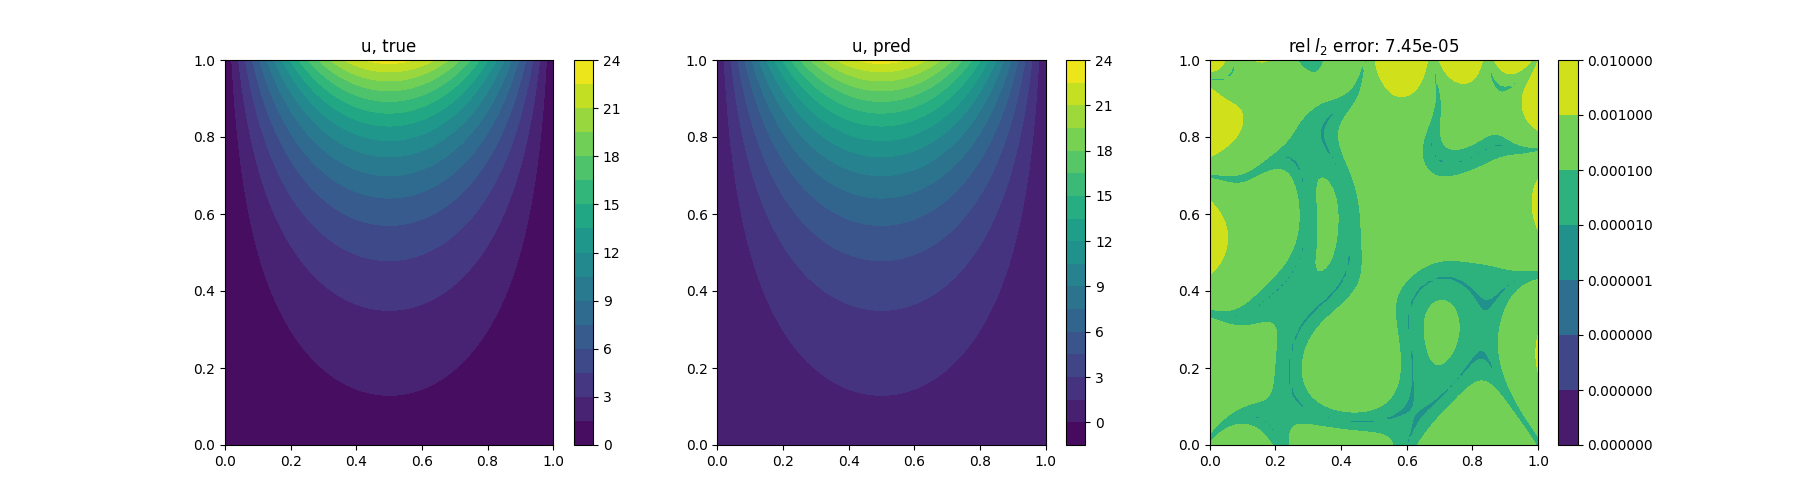

In [8]:
checkpoint_callback = trainer.callbacks[-1]
checkpoint = torch.load(checkpoint_callback.best_model_path)
pinn.load_state_dict(checkpoint["state_dict"])

x_test = torch.from_numpy(x_domain).to(pinn.device)
y_test = torch.from_numpy(y_domain).to(pinn.device)
u_test = u_fn(x_domain, y_domain).reshape((len(x_1d), len(y_1d))).T
with torch.no_grad():
    u_pred = pinn.forward(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
u_err = np.sqrt(np.mean((u_test - u_pred)**2))
u_norm = np.sqrt(np.mean(u_test**2))

X, Y = np.meshgrid(x_1d, y_1d)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
cmap = mpl.cm.viridis
	
fig, axes = plt.subplots(1, 3, figsize = (18, 5))
c0 = axes[0].contourf(X, Y, u_test, cmap = cmap, levels = 20)
c1 = axes[1].contourf(X, Y, u_pred, cmap = cmap, levels = 20)
c2 = axes[2].contourf(X, Y, np.abs(u_test - u_pred), cmap = cmap, norm = mpl.colors.LogNorm())

for c, ax in zip([c0, c1, c2], axes):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes, ["u, true", "u, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)